In [1]:
import os
import glob
from rasterio.windows import Window
import rasterio
import json
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon
import pyproj
import math
from rasterio import transform
import pickle as pkl
from tqdm import tqdm
from tensorflow import keras
import multiprocessing.dummy as mp 
from functools import partial
import timeit
import matplotlib.pyplot as plt
from rasterio.plot import show_hist
%matplotlib inline
from matplotlib import pyplot
from rasterio.plot import show
from sklearn.preprocessing import MinMaxScaler
from numpy import median
import os
import shutil
import io
import requests
import matplotlib.pyplot as plt

In [2]:
import satellite_images_nso.api.sat_manipulator as sat_manipulator
import satellite_images_nso.miscellaneous.miscellaneous as nso_miscellaneous
from satellite_images_nso.__normalisation import normalisation

In [ ]:
#blackspot in waterleiding duinen from wgs84 to new RD
Y_blackspot = 52.329134653707435
X_blackspot = 4.527157064969839
Y_blackspot = 96374
X_blackspot = 482704

Y_blackspot_2 = 96369.528 
X_blackspot_2 = 482677.768

In [52]:
blackspot_array = []
for file in glob.glob("C:/repos/satellite-images-nso/output/*50cm*aaneensluitende_polygon_cropped.tif"):
    print(file)  
    #nso_miscellaneous.plot_tif_file(file.replace("\\","/"))
    src = rasterio.open(file.replace("\\","/"))
    window = Window(8677, 7537, 1, 1)
    blackspot_array.append([file,src.read(window=window)])

C:/repos/satellite-images-nso/output\20190302_105724_SV1-01_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif
C:/repos/satellite-images-nso/output\20190422_111333_SV1-01_50cm_RD_11bit_RGBI_Noordwijkerhout_waterleidingduin_aaneensluitende_polygon_cropped.tif
C:/repos/satellite-images-nso/output\20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif
C:/repos/satellite-images-nso/output\20200304_114559_SV1-02_SV_RD_11bit_RGBI_50cm_Noordwijkerhout_waterleidingduin_aaneensluitende_polygon_cropped.tif
C:/repos/satellite-images-nso/output\20201109_111056_SV1-03_SV_RD_11bit_RGBI_50cm_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif
C:/repos/satellite-images-nso/output\20210426_112146_SV1-03_SV_RD_11bit_RGBI_50cm_Hillegom_waterleidingduin_aaneensluitende_polygon_cropped.tif


In [59]:
blackspot_array

[['C:/repos/satellite-images-nso/output\\20190302_105724_SV1-01_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif',
  array([[[433]],
  
         [[404]],
  
         [[347]],
  
         [[498]]], dtype=uint16)],
 ['C:/repos/satellite-images-nso/output\\20190422_111333_SV1-01_50cm_RD_11bit_RGBI_Noordwijkerhout_waterleidingduin_aaneensluitende_polygon_cropped.tif',
  array([[[405]],
  
         [[404]],
  
         [[374]],
  
         [[759]]], dtype=uint16)],
 ['C:/repos/satellite-images-nso/output\\20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif',
  array([[[381]],
  
         [[364]],
  
         [[247]],
  
         [[825]]], dtype=uint16)],
 ['C:/repos/satellite-images-nso/output\\20200304_114559_SV1-02_SV_RD_11bit_RGBI_50cm_Noordwijkerhout_waterleidingduin_aaneensluitende_polygon_cropped.tif',
  array([[[371]],
  
         [[351]],
  
         [[272]],
  
         [[511]]], dtype=uint16)],
 ['C:/rep

In [72]:
red = []
green = []
blue = []

for aarray in blackspot_array:
    print(red.append(aarray[1][0][0][0]))
    print(green.append(aarray[1][1][0][0]))
    print(blue.append(aarray[1][2][0][0]))

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


In [56]:
red_median = pd.Series(red).median()
green_median = pd.Series(green).median()
blue_median = pd.Series(blue).median()

In [87]:
blackspot_coefficients = []

In [89]:
for blackspot in blackspot_array:
    
    print(red_median-blackspot[1][0][0][0])
    blackspot_coefficients.append([blackspot[0],[red_median-blackspot[1][0][0][0], green_median-blackspot[1][1][0][0],blue_median-blackspot[1][2][0][0]]])

-40.0
-12.0
12.0
22.0
322.0
-68.0


In [91]:
blackspot_coefficients[2][1]

[12.0, 29.0, 146.0]

In [83]:
path_to_tif = 'C:/repos/satellite-images-nso/output/20190422_111333_SV1-01_50cm_RD_11bit_RGBI_Noordwijkerhout_waterleidingduin_aaneensluitende_polygon_cropped.tif'

In [98]:
pd.DataFrame(blackspot_coefficients).to_csv("")

,0,1
0,C:/repos/satellite-images-nso/output\20190302_...,"[-40.0, -11.0, 46.0]"
1,C:/repos/satellite-images-nso/output\20190422_...,"[-12.0, -11.0, 19.0]"
2,C:/repos/satellite-images-nso/output\20190729_...,"[12.0, 29.0, 146.0]"
3,C:/repos/satellite-images-nso/output\20200304_...,"[22.0, 42.0, 121.0]"
4,C:/repos/satellite-images-nso/output\20201109_...,"[322.0, 315.0, 259.0]"
5,C:/repos/satellite-images-nso/output\20210426_...,"[-68.0, -26.0, 14.0]"


In [3]:
blackspot_coefficients = pd.read_csv("blackspot_coefficients.csv")

In [11]:
path_to_tif = blackspot_coefficients['0'][3].replace("\\","/")

In [8]:
path_to_tif

'C:/repos/satellite-images-nso/output/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif'

In [12]:
blue_diff_add = float(blackspot_coefficients['1'][3].replace("[","").replace("]","").split(",")[0])
green_diff_add = float(blackspot_coefficients['1'][3].replace("[","").replace("]","").split(",")[1])
red_diff_add = float(blackspot_coefficients['1'][3].replace("[","").replace("]","").split(",")[2])
nir_diff_add = 0

In [19]:
def plot_tif_with_RGBI_coefficitiens(path_to_tif, blue_diff_add, red_diff_add, green_diff_add, nir_diff_add):
    print(path_to_tif)
    print(blue_diff_add, green_diff_add, red_diff_add, nir_diff_add )
    src = rasterio.open(path_to_tif).read(masked=True)
    meta = rasterio.open(path_to_tif).meta.copy()

    fig, (axrgb, axhist) = pyplot.subplots(1, 2, figsize=(14,7))
    plot_out_image = np.clip(src[2::-1],
                        0,2200)/2200

    rasterio.plot.show(plot_out_image, ax=axrgb, title="Original")

    src[0] = src[0]+blue_diff_add
    src[1] = src[1]+green_diff_add 
    src[2] = src[2]+red_diff_add 
    src[3] = src[3]+nir_diff_add 

    outpath = path_to_tif.split(".")[0]+"_dark_point_normalised.tif"

    plot_out_image_2 = np.clip(src[2::-1],
                        0,2200)/2200

    rasterio.plot.show(plot_out_image_2, ax=axhist, title="Multi-date Dark Point Relative Normalisation")
    pyplot.show()

    with rasterio.open(outpath, 'w', **meta) as outds:        
        outds.write(src)

22.0 121.0 42.0 0


MemoryError: Unable to allocate 6.45 GiB for an array with shape (3, 18790, 15369) and data type float64

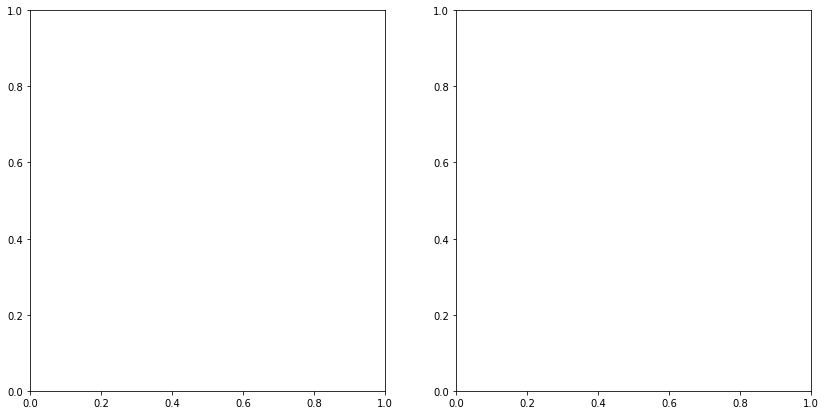

In [20]:
plot_tif_with_RGBI_coefficitiens(path_to_tif, blue_diff_add, green_diff_add, red_diff_add, nir_diff_add)

12.0 29.0 146.0 0


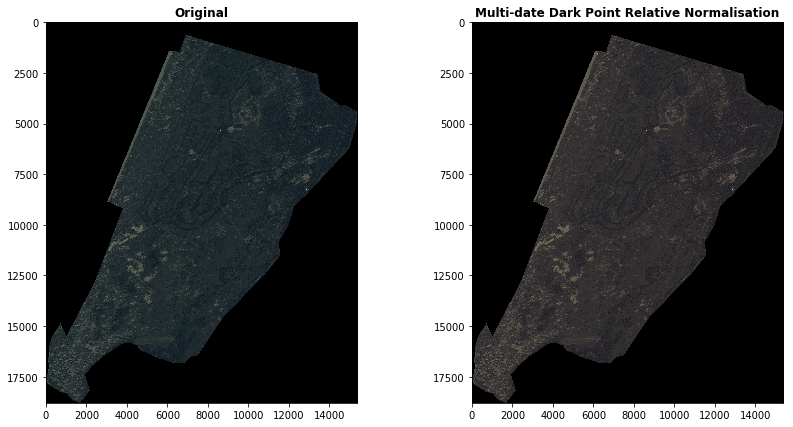

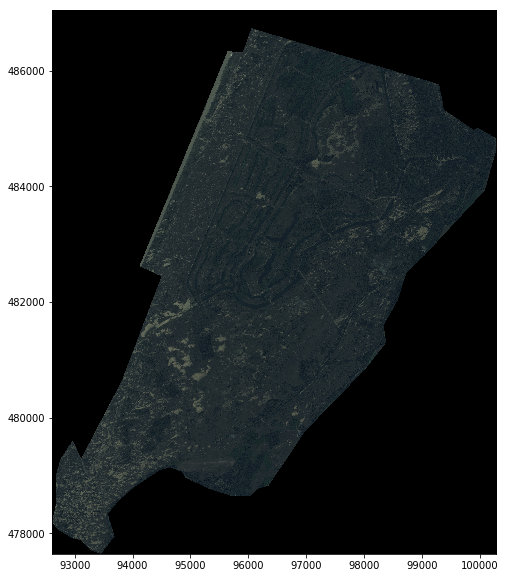

In [60]:
nso_miscellaneous.plot_tif_file('C:/repos/satellite-images-nso/output/20190729_111526_SV1-04_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif')

In [ ]:
sdf[(round(sdf["Y"],nummer_achter_de_comma) == round(Y_blackspot,nummer_achter_de_comma)) & (round(sdf["X"],nummer_achter_de_comma) == round(X_blackspot,nummer_achter_de_comma)) ]

In [ ]:
normalisation.multi_date_dark_spot_normalisation("C:/repos/satellite-images-nso/output/20190302_105724_SV1-01_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif",satellite_image_name = "20190302_105724_SV1-01_50cm_RD_11bit_RGBI" )

-------- Dark Spot Normalisation for file: 
C:/repos/satellite-images-nso/output/20190302_105724_SV1-01_50cm_RD_11bit_RGBI_Lisse_waterleidingduin_aaneensluitende_polygon_cropped.tif


In [10]:
src.xy(1,1)

(92606.25, 487041.75)

In [26]:
rasterio.transform.rowcol(src.transform, 96374, 482704)

(8677, 7537)

array([[[433]],

       [[404]],

       [[347]],

       [[498]]], dtype=uint16)